# Importing library

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Scraping data

In [2]:
base_url = "https://rumah.trovit.co.id/rumah-sangat-murah-bu-jakarta"

In [3]:
def extract_info(url,section,**kwargs):
    
    data = {}
    property_list = ["item-property item-rooms", "item-property item-baths", "item-property item-size"]

    for page_num in range(1,5):
        
        if page_num == 1:
            url = base_url

            web_page = requests.get(url)
            web_text = web_page.text
            soup = BeautifulSoup(web_text, 'html.parser')
            
            for key, value in kwargs.items():
                for iterator in value:
                    record = soup.find_all(section, {'class': iterator})

                    for record_data in record:

                        if iterator == 'item-properties basic-properties':

                            for property_data in property_list:
                                
                                item_data = record_data.find("div", {"class":property_data})

                                if item_data is not None:
                                    data_text = item_data.span.text
                                else:
                                    data_text = None

                                data[property_data] = []
                                data[property_data].append(data_text)

                        else:
                            
                            data[iterator] = []
                            data[iterator].append(record_data.text)


        else:
            
            url = str(base_url + '/{}'.format(page_num))

            web_page = requests.get(url)
            web_text = web_page.text
            soup = BeautifulSoup(web_text, 'html.parser')
            
            for key, value in kwargs.items():
                for iterator in value:
                    record = soup.find_all(section, {'class': iterator})
                    
                    for record_data in record:

                        if iterator == 'item-properties basic-properties':
                        
                            for property_data in property_list:

                                item_data = record_data.find("div", {"class":property_data})

                                if item_data is not None:
                                    data_text = item_data.span.text
                                else:
                                    data_text = None

                                data[property_data].append(data_text)
                        
                        else:

                            data[iterator].append(record_data.text)


    return data

In [4]:
class_list = ['item-title','item-description','item-properties basic-properties','item-price']
data = extract_info(base_url,'div',class_list = class_list)

In [5]:
for key in data:print(key, len(data[key]))

item-title 74
item-description 74
item-property item-rooms 74
item-property item-baths 74
item-property item-size 74
item-price 74


# Preprocessing Data

In [6]:
df = pd.DataFrame(data)

In [7]:
df['item-property item-rooms'] = df['item-property item-rooms'].str.replace('\xa0KT','')
df['item-property item-baths'] = df['item-property item-baths'].str.replace('\xa0KM','')
df['item-property item-size'] = df['item-property item-size'].str.replace('\xa0m²','')

In [8]:
state_list = ["Jakarta Barat","Jakarta Selatan","Jakarta Utara","Jakarta Pusat","Jakarta Timur"]

holder_state = []
for string in data['item-title']:

    leng_holder_before = len(holder_state)

    for state in state_list:

        if state in string:
            
            holder_state.append(state)        
            
    leng_holder_after = len(holder_state)

    if leng_holder_before == leng_holder_after:
        holder_state.append("Outside Jakarta")

In [9]:
df['location'] = holder_state

In [10]:
df.dropna(inplace=True)

In [13]:
from decimal import Decimal

df['item-price'] = df['item-price'].str.replace(' Rp 1,600,000,000  Rp 1,625,000,000  2%    ','Rp 1,600,000,000')
df['item-price'] = df['item-price'].str.replace(' Rp 2,750,000,000  Rp 2,950,000,000  7%    ','Rp 2,750,000,000')
df['item-price'] = df['item-price'].str.replace(' 2400000000  2700000000  12%    ','Rp 2,700,000,000')
df['item-price'] = df['item-price'].str.replace(' Lihat harga ','Rp 0')

def convert_currency(val):
    return Decimal(val.replace('Rp ', '').replace(',', ''))

df['item-price'] = df['item-price'].apply(convert_currency)
df['item-price'] = df['item-price'].astype('float')

In [14]:
df = df.dropna(subset=['item-property item-rooms','item-property item-baths','item-property item-size'])

df['item-property item-rooms'] = df['item-property item-rooms'].astype(int)
df['item-property item-baths'] = df['item-property item-baths'].astype(int)
df['item-property item-size'] = df['item-property item-size'].astype(int)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 69
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   item-title                59 non-null     object 
 1   item-description          59 non-null     object 
 2   item-property item-rooms  59 non-null     int32  
 3   item-property item-baths  59 non-null     int32  
 4   item-property item-size   59 non-null     int32  
 5   item-price                59 non-null     float64
 6   location                  59 non-null     object 
dtypes: float64(1), int32(3), object(3)
memory usage: 3.0+ KB


In [16]:
df = df.drop_duplicates()

In [17]:
df

,item-title,item-description,item-property item-rooms,item-property item-baths,item-property item-size,item-price,location
0,Rumah Murah Jakarta Timur Duren Sawit Strateg...,Rumah Murah Jakarta Timur Duren Sawit Strateg...,6,4,499,7.000000e+09,Jakarta Timur
1,Golf Island Pantai Indah Kapuk,Rumah Murah Rumah Bagus Rumah Siap Huni Rumah...,4,4,450,1.050000e+10,Outside Jakarta
2,Rawamangun,"Rumah dijual cepat, sangat BU. Harga Murah. L...",4,3,250,3.400000e+09,Outside Jakarta
3,"Rumah dijual di Bangka, Jakarta Selatan IDR 1...",Dijual rumah FF bagus dan sangat terawat di J...,4,4,800,1.700000e+10,Jakarta Selatan
4,Rumah Murah Jakarta Timur Duren Sawit Strateg...,Rumah Murah Jakarta Timur Duren Sawit Strateg...,6,4,435,7.000000e+09,Jakarta Timur
5,Dijual Cepat Murah Rumah Luas Di Lubang Buaya...,Dijual BU Rumah 2 Lantai Full Furnish Megah B...,7,6,704,8.500000e+09,Jakarta Timur
6,Rumah jakarta murah di pejaten timur pasar mi...,"Dijual Cepat Rumah (BU) Hitung tanah, harga t...",2,1,60,8.500000e+08,Outside Jakarta
7,"Rumah dijual di Ancol, Jakarta Utara IDR 8000...",Dijual Sangat Murah BU Pangandaran 7 Ancol Ba...,5,3,750,8.000000e+09,Jakarta Utara
8,Rumah murah strategis di permata Cimanggis,"Jual BU, jauh di bawah harga pasar. Rumah sia...",2,1,60,5.950000e+08,Outside Jakarta
9,"Rumah dijual di Johar Baru, Jakarta Pusat IDR...","Rumah tua ini dijual cepat cepat dan BU, loka...",2,1,200,2.700000e+09,Jakarta Pusat


# EDA

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

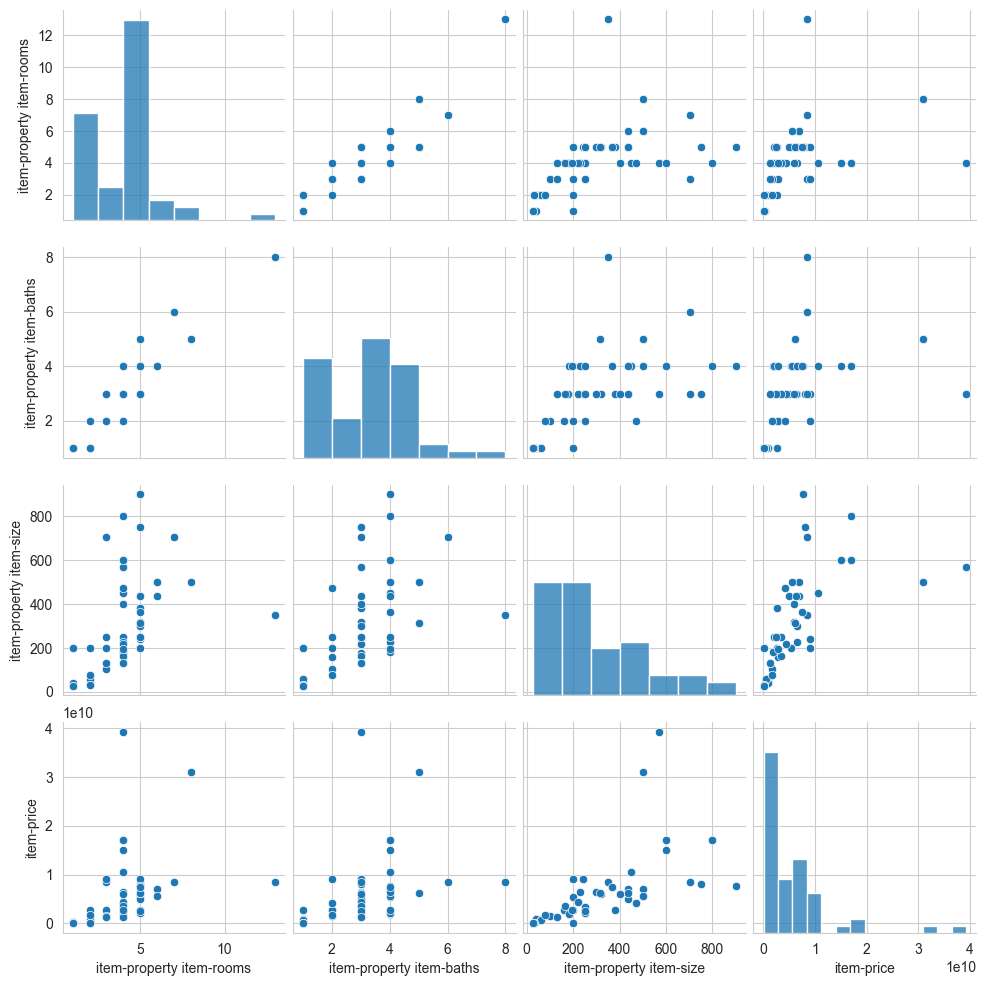

In [25]:
sns.pairplot(df)

In [26]:
df.describe()

,item-property item-rooms,item-property item-baths,item-property item-size,item-price
count,57.000000,57.000000,57.000000,5.700000e+01
mean,3.894737,2.824561,288.140351,5.565480e+09
std,1.979215,1.465347,222.534382,7.024593e+09
min,1.000000,1.000000,28.000000,3.000000e+07
25%,2.000000,1.000000,102.000000,1.299900e+09
50%,4.000000,3.000000,242.000000,3.400000e+09
75%,5.000000,4.000000,435.000000,7.000000e+09
max,13.000000,8.000000,900.000000,3.925000e+10


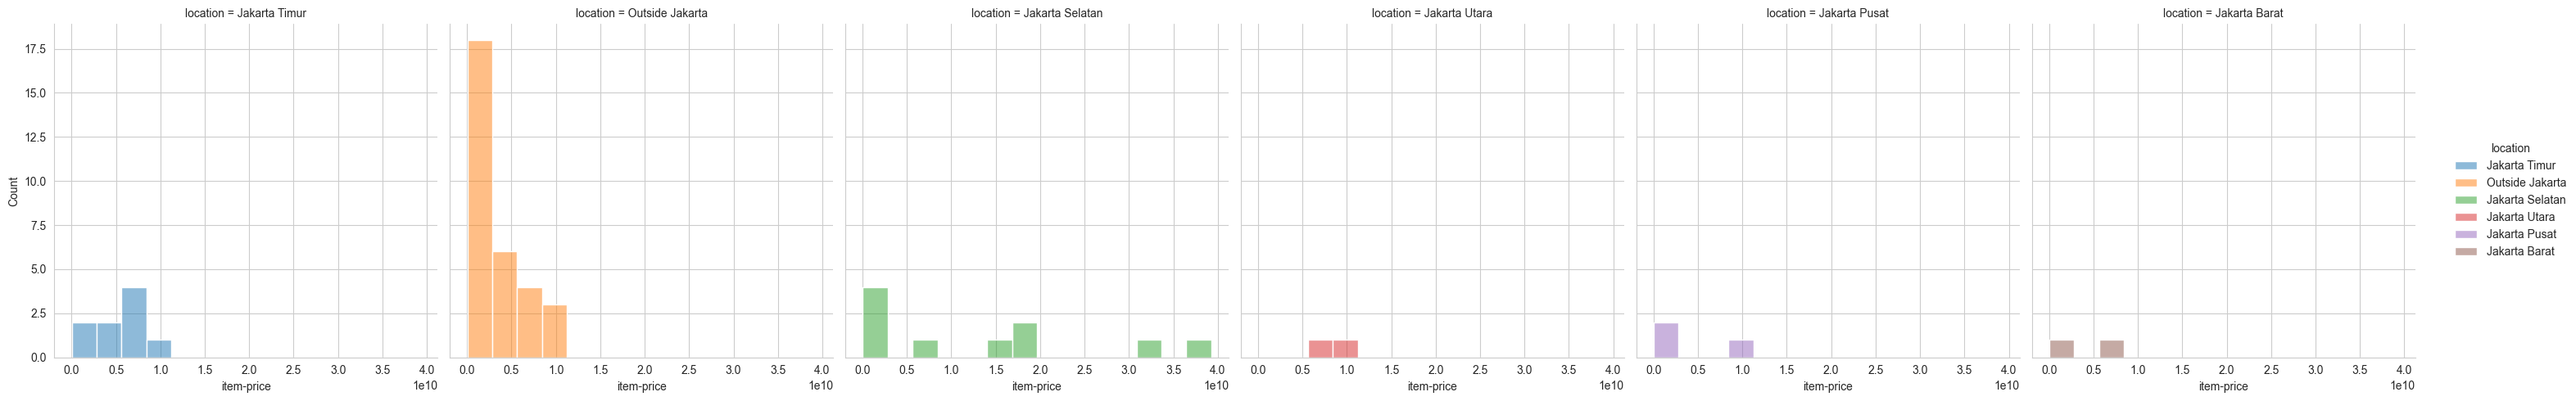

In [28]:
sns.displot(df, x="item-price", hue="location", col="location")

C:\Users\Mario\AppData\Local\Temp\ipykernel_8080\3430030795.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method="pearson")


<Axes: >

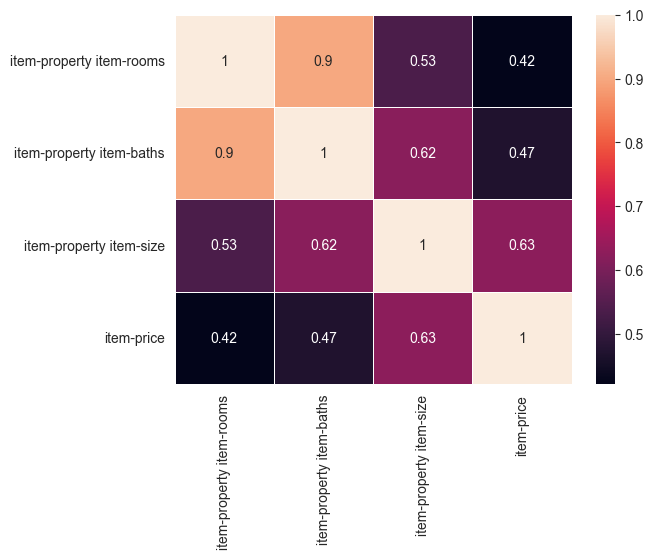

In [29]:
correlation_matrix = df.corr(method="pearson")

sns.heatmap(correlation_matrix, annot=True, linewidths=.5)